# Mount my drive

In [16]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read the csv file

In [1]:
import pandas as pd
tbc_df = pd.read_csv('/content/drive/My Drive/Datasets for Satellite Telemetry Anomaly Detection/TotalBusCurrent.csv')

# Show dimensions & file head

In [2]:
print('dimensions :', tbc_df.shape)
display(tbc_df.head())

dimensions : (5346, 2)


,Time,Current
0,2004-02-13,11.799583
1,2004-02-14,11.826283
2,2004-02-15,11.804309
3,2004-02-16,11.803606
4,2004-02-17,11.239218


In [3]:
tbc_df.columns

Index(['Time', 'Current  '], dtype='object')

In [4]:
# rename 'Current  ' to 'Current'
tbc_df.rename(columns = {'Current  ':'Current'}, inplace=True)

# description // summary // column types

In [5]:
display(tbc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5346 entries, 0 to 5345
Data columns (total 2 columns):
Time       5346 non-null object
Current    5346 non-null float64
dtypes: float64(1), object(1)
memory usage: 83.7+ KB


None

# convert 'Time' from object {string} to datetime 

In [6]:
tbc_df['Time'] = pd.to_datetime(tbc_df['Time'])

In [7]:
display(tbc_df.describe())

,Current
count,5346.000000
mean,11.000226
std,1.714305
min,0.000000
25%,11.043942
50%,11.503806
75%,11.861526
max,12.714043


# Pandas profile report

In [49]:
!pip install pandas==0.25.3
!pip install pandas-profiling
!pip install matplotlib-venn


In [8]:
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

tbc_df.head()

,Time,Current
0,2004-02-13,11.799583
1,2004-02-14,11.826283
2,2004-02-15,11.804309
3,2004-02-16,11.803606
4,2004-02-17,11.239218


In [9]:

ProfileReport(tbc_df)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,2
Number of observations,5346
Total Missing (%),0.0%
Total size in memory,83.7 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,0


# plot 'current' against 'time'

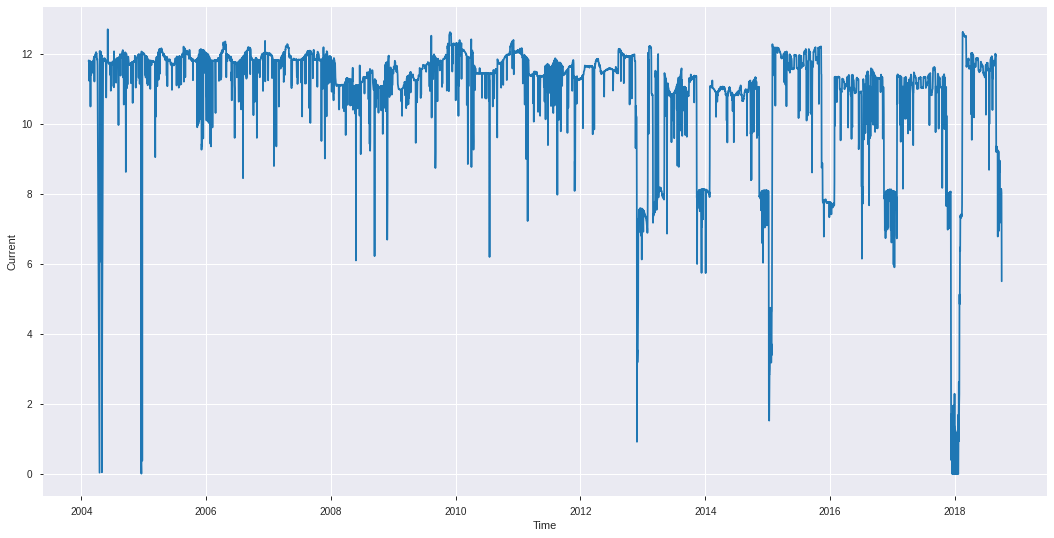

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.figure(figsize=(18, 9))
plt.xlabel('Time')
plt.ylabel('Current')
plt.plot(tbc_df['Time'], tbc_df['Current'])
plt.show()

# We have to convert the datetime into one of these :


*   An ordinal column which starts from 1 (start day) and increment every day by 1.
*   3 columns (year, month, day).
*   One hot encoding (a column for each year (15) + a column for each month (12) + a column for each day (31)) == (58)



## At first we will try the option number 2, because it's more represntative and has reasonable number of columns.

In [11]:
tbc_df['Year'] = pd.DatetimeIndex(tbc_df['Time']).year
tbc_df['Month'] = pd.DatetimeIndex(tbc_df['Time']).month
tbc_df['Day'] = pd.DatetimeIndex(tbc_df['Time']).day

In [12]:
print('dimensions :', tbc_df.shape)
display(tbc_df.head())

dimensions : (5346, 5)


,Time,Current,Year,Month,Day
0,2004-02-13,11.799583,2004,2,13
1,2004-02-14,11.826283,2004,2,14
2,2004-02-15,11.804309,2004,2,15
3,2004-02-16,11.803606,2004,2,16
4,2004-02-17,11.239218,2004,2,17


# Split the data into training, validation and testing datasets

## Desplay the number of rows in each data set and show the percentage to the orignal data

In [15]:
print('Thole data dimensions :', tbc_df.shape)
train_df = tbc_df[tbc_df['Year']<2017]
print('Training dimensions   : {} , percentage : {:.2f}%'.format(train_df.shape, len(train_df)/len(tbc_df)*100))
valid_df = tbc_df[tbc_df['Year']==2017]
print('Validation dimensions : {} ,  percentage : {:.2f}%'.format(valid_df.shape, len(valid_df)/len(tbc_df)*100))
test_df = tbc_df[tbc_df['Year']==2018]
print('Testing dimensions    : {} ,  percentage : {:.2f}%'.format(test_df.shape, len(test_df)/len(tbc_df)*100))

Thole data dimensions : (5346, 5)
Training dimensions   : (4706, 5) , percentage : 88.03%
Validation dimensions : (365, 5) ,  percentage : 6.83%
Testing dimensions    : (275, 5) ,  percentage : 5.14%


# Split datasets into features(x) and target(y)

In [16]:
X_train = train_df[['Year', 'Month', 'Day']]
y_train = train_df['Current']

X_valid = valid_df[['Year', 'Month', 'Day']]
y_valid = valid_df['Current']

X_test = test_df[['Year', 'Month', 'Day']]
y_test = test_df['Current']

# Implementing the error metrics functions

*   the (MAPE) stands for Mean Absolute Percentage Error 
*   the (WAPE) stands for Weighted Absolute Percentage Error



In [17]:
def mape(y_true, y_pred):
    error = 0
    zcount = 0
    for t, p in zip(y_true, y_pred):
        if(t>0):
            error += abs(t-p)/t
        else:
            zcount+=1
    error /= (len(y_true)-zcount)*100
    print('zeros count =', zcount)
    return error

def wape(y_true, y_pred):
    return abs(sum(y_true)-sum(y_pred))/sum(y_true)*100

# Tessting the Linear model for our data

In [18]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(n_jobs=-1)

### Fit the model

In [19]:
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

### Calculate the R^2, MAPE and WAPE 

In [24]:
print('R^2 sscore =', linear_reg.score(X_valid, y_valid))
print('MAPE = {:.2f}%'.format(mape(y_valid, linear_reg.predict(X_valid))))
print('WAPE = {:.2f}%'.format(wape(y_valid, linear_reg.predict(X_valid))))

R^2 sscore = 0.00977381979018832
zeros count = 5
MAPE = 0.01%
WAPE = 2.37%


# Visualizing the data in comperance with this model

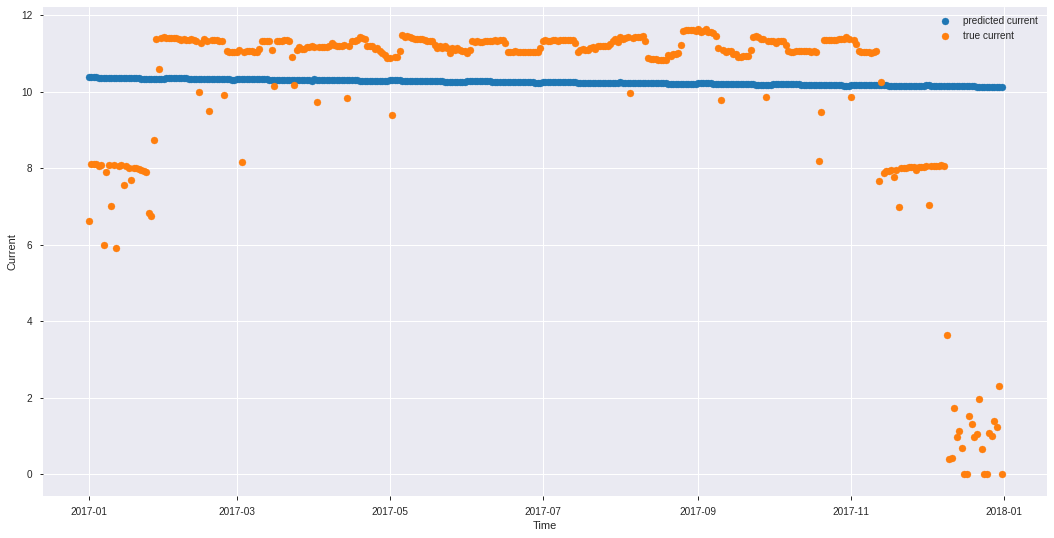

In [25]:
plt.figure(figsize=(18, 9))
plt.xlabel('Time')
plt.ylabel('Current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], linear_reg.predict(X_valid), label='predicted current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], y_valid, label='true current')
plt.legend()
plt.show()

# Tessting the  Quadratic model for our data

In [26]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
new_X_train = poly.fit_transform(X_train)

linear_reg.fit(new_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

## Branshing the data for fitting with the new model

In [29]:
new_X_valid = poly.fit_transform(X_valid)
print('R^2 sscore =', linear_reg.score(new_X_valid, y_valid))
print('MAPE = {:.2f}%'.format(mape(y_valid, linear_reg.predict(new_X_valid))))
print('WAPE = {:.2f}%'.format(wape(y_valid, linear_reg.predict(new_X_valid))))

R^2 sscore = 0.2419090513423221
zeros count = 5
MAPE = 0.01%
WAPE = 2.32%


# Visualizing the data in comperance with this model

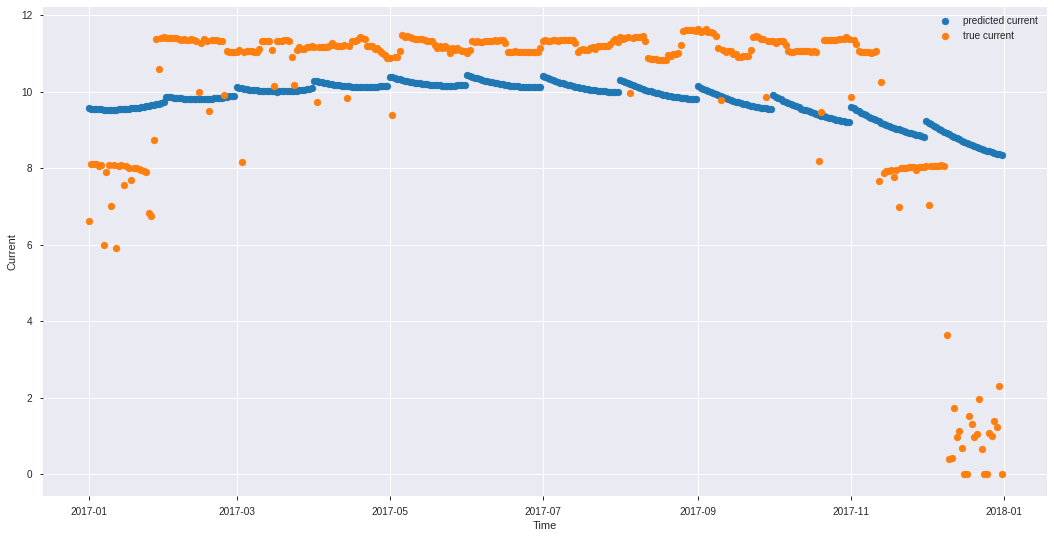

In [30]:
plt.figure(figsize=(18, 9))
plt.xlabel('Time')
plt.ylabel('Current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], linear_reg.predict(new_X_valid), label='predicted current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], y_valid, label='true current')
plt.legend()
plt.show()

#### This model if better than the linear model but still doesn't fit it enough, we will try to increase the degree

In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
new_X_train = poly.fit_transform(X_train)

linear_reg.fit(new_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [32]:
new_X_valid = poly.fit_transform(X_valid)
print('R^2 sscore =', linear_reg.score(new_X_valid, y_valid))
print('MAPE = {:.2f}%'.format(mape(y_valid, linear_reg.predict(new_X_valid))))
print('WAPE = {:.2f}%'.format(wape(y_valid, linear_reg.predict(new_X_valid))))

R^2 sscore = 0.5015923843977229
zeros count = 5
MAPE = 0.00%
WAPE = 4.36%


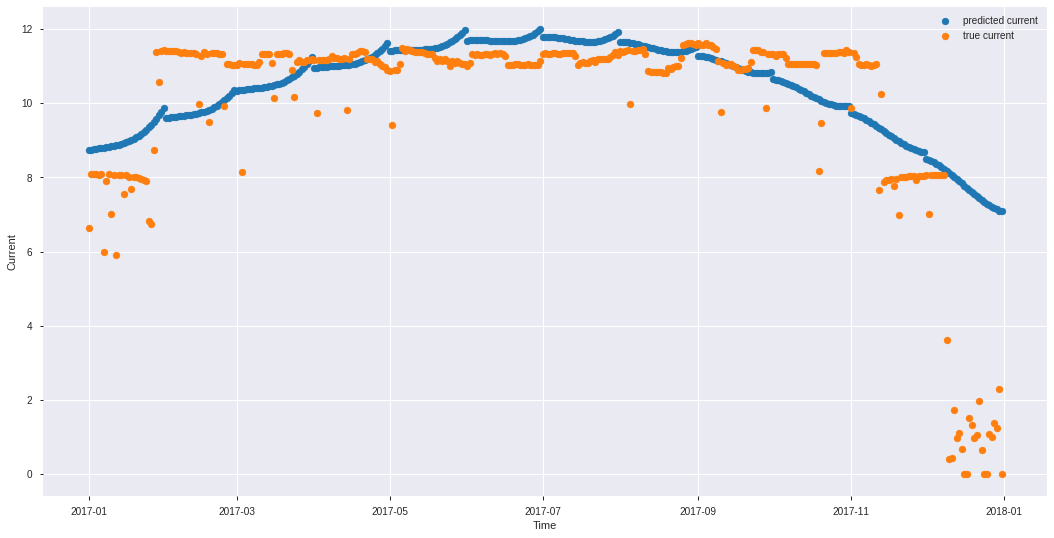

In [33]:
plt.figure(figsize=(18, 9))
plt.xlabel('Time')
plt.ylabel('Current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], linear_reg.predict(new_X_valid), label='predicted current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], y_valid, label='true current')
plt.legend()
plt.show()

## This shows that, the model is fitting our data more

# Trying the Support Vector Machines

In [44]:
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train, y_train)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [48]:
print('R^2 sscore =', regr.score(X_valid, y_valid))
print('MAPE = {:.2f}%'.format(mape(y_valid, regr.predict(X_valid))))
print('WAPE = {:.2f}%'.format(wape(y_valid, regr.predict(X_valid))))

R^2 sscore = -0.041355941367173354
zeros count = 5
MAPE = 0.01%
WAPE = 5.39%


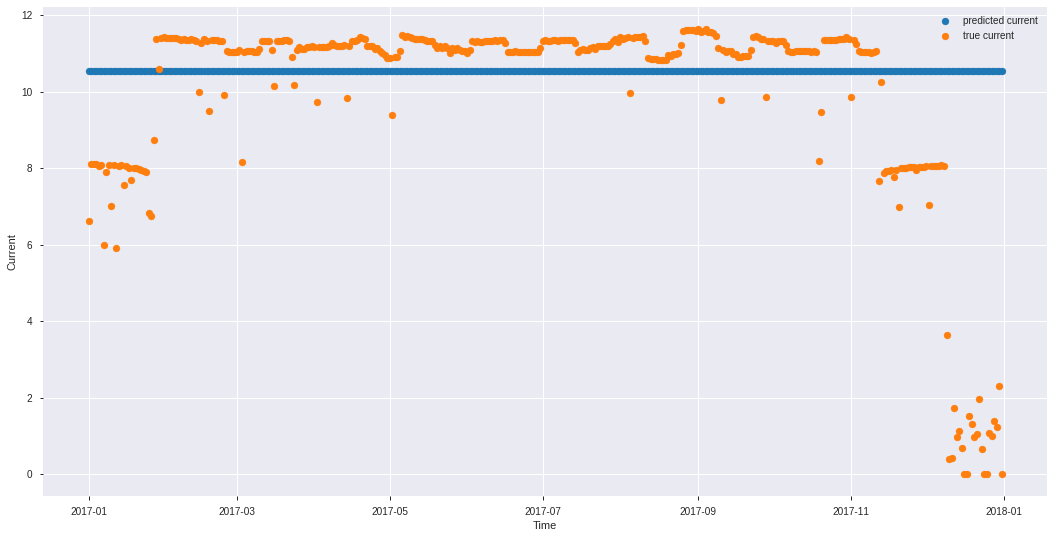

In [49]:
plt.figure(figsize=(18, 9))
plt.xlabel('Time')
plt.ylabel('Current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], regr.predict(X_valid), label='predicted current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], y_valid, label='true current')
plt.legend()
plt.show()

# Implmenting the Decision Trees model

In [63]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)


In [65]:
print('R^2 sscore =', clf.score(X_valid, y_valid))
print('MAPE = {:.2f}%'.format(mape(y_valid, clf.predict(X_valid))))
print('WAPE = {:.2f}%'.format(wape(y_valid, clf.predict(X_valid))))

R^2 sscore = -0.9589072006243896
zeros count = 5
MAPE = 0.01%
WAPE = 21.12%


## Visualizing the result

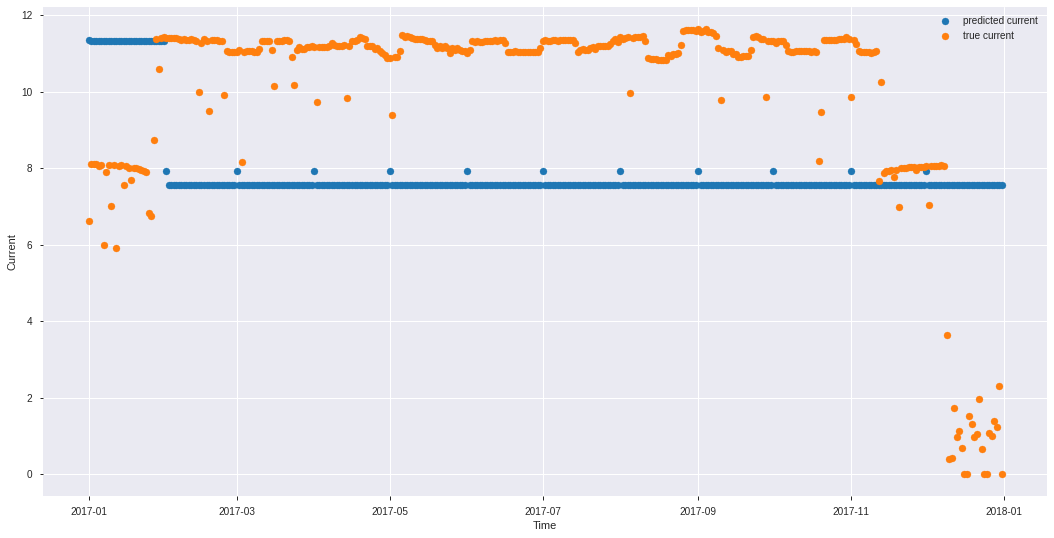

In [66]:
plt.figure(figsize=(18, 9))
plt.xlabel('Time')
plt.ylabel('Current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], clf.predict(X_valid), label='predicted current')
plt.scatter(tbc_df[tbc_df['Year']==2017]['Time'], y_valid, label='true current')
plt.legend()
plt.show()

# Implementing the Random Forest Regressor model 

In [114]:
import numpy as np
from numpy import nan
import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = pd.read_csv('/content/drive/My Drive/Datasets for Satellite Telemetry Anomaly Detection/BatteryTemperature.csv')

## Sclicing and reshaping the data

In [115]:
X=df.iloc[:,0]
y=df.iloc[:,-1].values
X=pd.to_datetime(X)
X=X.values

In [116]:
X=X.reshape(-1, 1)
y=y.reshape(-1, 1)

## Implementing the model

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(y)
standardized=scaler.transform(y)

In [118]:
np.std(standardized)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [119]:
from sklearn.ensemble  import RandomForestRegressor
from sklearn.metrics import r2_score
regr = RandomForestRegressor()

### Fitting the model

In [120]:
regr.fit(X_train,y_train)
y_pred=regr.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


### Measuring the R^2

In [122]:
score= r2_score(y_test,y_pred)
print('The R^2 score = ', score)

The R^2 score =  0.9529801319969279


# Visualizing the result

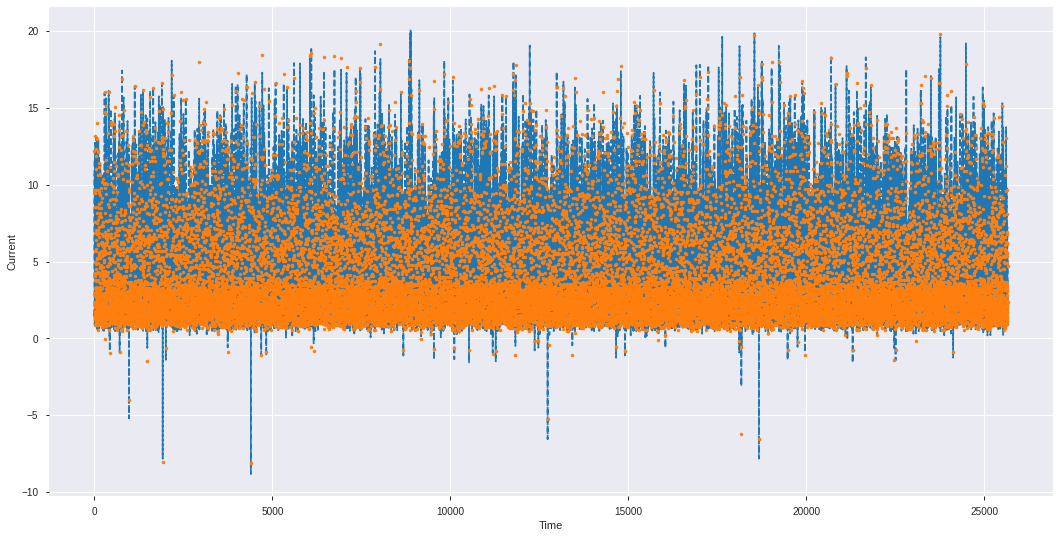

In [123]:
plt.figure(figsize=(18, 9))
plt.xlabel('Time')
plt.ylabel('Current')
plt.plot(y_test ,'--', y_pred,'.')
plt.show()

# *Predicting the Anomaly Detection*

In [138]:
year = input("Enter the year:") 
month= input("Enter the month:") 
day= input("Enter the day: ") 
date=year+'-'+month+'-'+day
print(date)

Enter the year:2005
Enter the month:10
Enter the day: 14
2005-10-14


In [146]:
a=np.datetime64('2018-10-02 20:00:00', 'ns')
a=a.reshape(-1, 1)
u=regr.predict(a)
print(u)


[0.87800932]


In [144]:
df.tail()

,Time,Temperature
128284,2018-10-02 19:00:00,0.593578
128285,2018-10-02 20:00:00,0.593578
128286,2018-10-02 21:00:00,0.593578
128287,2018-10-02 22:00:00,0.593578
128288,2018-10-02 23:00:00,0.593578
